# Iron Condor Deep Hedging with Tensorflow

* Course: Introduction to Financial Engineering - by Joocheol Kim

* by [Dongha Kim](https://github.com/kdha0727) - Yonsei Univ. College of Medicine Premedical course

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

np.random.seed(1234)
tf.random.set_seed(1234)

%matplotlib inline

# About Iron Condor Deep Hedging

## What is Iron Condor?

An iron condor is an options strategy consisting of two puts (one long and one short) and two calls (one long and one short), and four strike prices, all with the same expiration date. The iron condor earns the maximum profit when the underlying asset closes between the middle strike prices at expiration. In other words, the goal is to profit from low volatility in the underlying asset.

The iron condor has a similar payoff as a regular condor spread, but uses both calls and puts instead of only calls or only puts. Both the condor and the iron condor are extensions of the butterfly spread and iron butterfly, respectively.

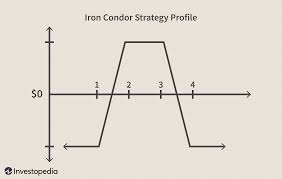

In [2]:
# Set Hyper Parameters for Iron Condor

K_1 = 0.9; K_2 = 0.95; K_3 = 1.05; K_4 = 1.1

# Set Other Values

S0=1.; r=.0; sig=.2; T=30/365; M=1000; N=30
dt = T/N; rdt = r*dt; sigsdt = sig * np.sqrt(dt)


In [3]:
# Prepare Values

S = np.empty([M, N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

## What is Deep Hedging?

Deep Hedging goes back to the following [paper](https://arxiv.org/abs/1802.03042)  by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood. 

The main idea is to parametrize the hedging strategies (at each time) via neural networks which can depend on input variables chosen by the user, for instance the current price, the past strategy, etc.
This then allows to solve a potentially high dimensional hedging problem for many assets whose dynamics are described by an arbitrary given arbitrage free model even in the presence of transaction costs.

* I implemented my model like below picture.

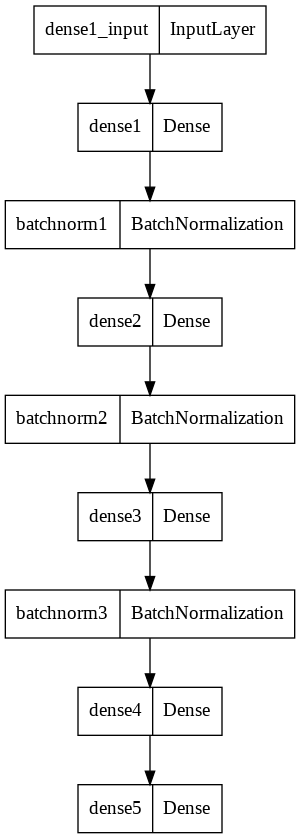

In [4]:
# My delta model

def delta_model(name=None):
    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.Dense(32, activation='tanh', name="dense1"))
    model.add(tf.keras.layers.BatchNormalization(name='bn1'))
    model.add(tf.keras.layers.Dense(64, activation='tanh', name="dense2"))
    model.add(tf.keras.layers.BatchNormalization(name='bn2'))
    model.add(tf.keras.layers.Dense(32, activation='tanh', name="dense3"))
    model.add(tf.keras.layers.BatchNormalization(name='bn3'))
    model.add(tf.keras.layers.Dense(16, activation='tanh', name="dense4"))
    model.add(tf.keras.layers.Dense(1, activation='tanh', name="dense5"))
    return model

delta_model_example = delta_model(name="My Model")
delta_model_example.build(input_shape=(None, 1))
delta_model_example.summary()

Model: "My Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 32)                64        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 32)                128       
_________________________________________________________________
dense2 (Dense)               (None, 64)                2112      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 64)                256       
_________________________________________________________________
dense3 (Dense)               (None, 32)                2080      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 32)                128       
_________________________________________________________________
dense4 (Dense)               (None, 16)                528

In [5]:
# Price Function Def

def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)


def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)


def visualize(model, history, S, x, suptitle):
    y_loss = history.history['loss']
    x_range = np.arange(len(y_loss))
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(x_range, y_loss, marker='.', c='red', label="Validation-set Loss")
    ax1.set_title("Train Loss", fontsize=20)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.hist(model.predict(x))
    ax2.set_title("Prediction Histogram")
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(S[:,-1], model.predict(x), marker=".", linestyle='none')
    ax3.set_title("Prediction Scatters")
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=25)
    plt.show() 

# Implementation with Call Options

## Simulation

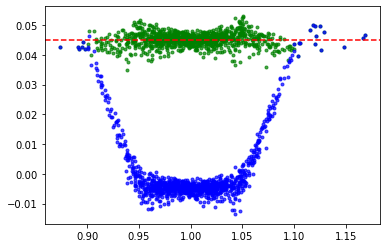

In [6]:
a = []
b = []

for i in range(M):
    cost = hedge = 0.
    for j in range(N):
        delta_1 = norm.cdf((np.log(S[i,j]/K_1)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_2 = norm.cdf((np.log(S[i,j]/K_2)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_3 = norm.cdf((np.log(S[i,j]/K_3)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_4 = norm.cdf((np.log(S[i,j]/K_4)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta = delta_1 - delta_2 - delta_3 + delta_4
        cost = cost + (delta - hedge) * S[i,j]
        hedge = delta
    cost = cost - hedge * S[i,N]
    a.append(cost)
    cost += (
        np.maximum(S[i,N]-K_1, 0) - np.maximum(S[i,N]-K_2, 0)
        - np.maximum(S[i,N]-K_3, 0) + np.maximum(S[i,N]-K_4, 0)
    )
    b.append(cost)

plt.plot(S[:,-1], b, marker=".", c="g", alpha=0.7, linestyle='none')
plt.plot(S[:,-1], a, marker=".", c="b", alpha=0.7, linestyle='none')
premium = (
    bscall(S0, K_1, T, r, sig) - bscall(S0, K_2, T, r, sig)
    - bscall(S0, K_3, T, r, sig) + bscall(S0, K_4, T, r, sig)
)
plt.axhline(y=premium, c='r', linestyle='--')
plt.show()


## Tensorflow Implementation

In [7]:
premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

inputs = [premium, hedge_cost, price]

for j in range(30):
    delta = delta_model(name='delta_model_%s' % j)(price)
    new_price = tf.keras.layers.Input(shape=(1,), name='S%s' % j)
    inputs.append(new_price)
    price_inc = tf.keras.layers.Subtract(name='price_inc_%s' % j)([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_%s" % j)([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_%s' % j)([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(
    lambda x : tf.math.maximum(x-K_1,0) - tf.math.maximum(x-K_2,0) - tf.math.maximum(x-K_3,0) + tf.math.maximum(x-K_4,0), 
    name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=inputs, outputs=cum_cost)
model.compile(loss='mse', optimizer='adam')
# model.summary()

In [8]:
premium = (
    bscall(S0,K_1,T,r,sig) * np.ones([M,1])
    - bscall(S0,K_2,T,r,sig) * np.ones([M,1])
    - bscall(S0,K_3,T,r,sig) * np.ones([M,1])
    + bscall(S0,K_4,T,r,sig) * np.ones([M,1])
)
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium] + [cost] + [SS]
y = np.zeros([M,1])

history = model.fit(x,y, batch_size=32, epochs=100,  verbose=True)

2021-11-28 20:36:45.200901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-28 20:36:45.201368: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095074999 Hz


Epoch 1/100
32/32 [==============================] - 51s 62ms/step - loss: 3.2129e-04
Epoch 2/100
32/32 [==============================] - 3s 81ms/step - loss: 6.5106e-05
Epoch 3/100
32/32 [==============================] - 3s 90ms/step - loss: 3.6052e-05
Epoch 4/100
32/32 [==============================] - 3s 83ms/step - loss: 3.2610e-05
Epoch 5/100
32/32 [==============================] - 3s 80ms/step - loss: 3.2094e-05
Epoch 6/100
32/32 [==============================] - 3s 88ms/step - loss: 3.4079e-05
Epoch 7/100
32/32 [==============================] - 3s 92ms/step - loss: 3.1882e-05
Epoch 8/100
32/32 [==============================] - 3s 83ms/step - loss: 3.1127e-05
Epoch 9/100
32/32 [==============================] - 2s 72ms/step - loss: 3.5525e-05
Epoch 10/100
32/32 [==============================] - 2s 71ms/step - loss: 3.5620e-05
Epoch 11/100
32/32 [==============================] - 2s 75ms/step - loss: 3.2051e-05
Epoch 12/100
32/32 [==============================] - 2s 72ms/

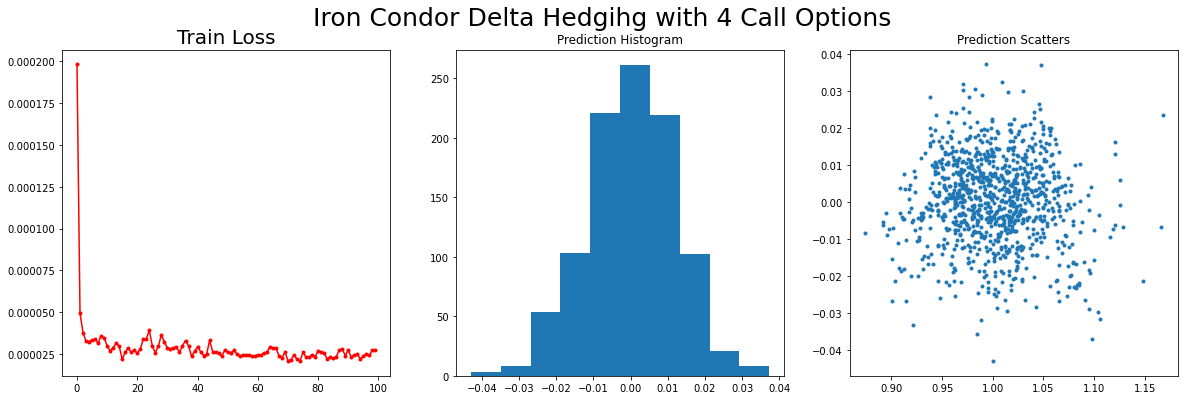

In [9]:
visualize(model, history, S, x, suptitle="Iron Condor Delta Hedgihg with 4 Call Options")

# Implementation with Put Options

## Simulation

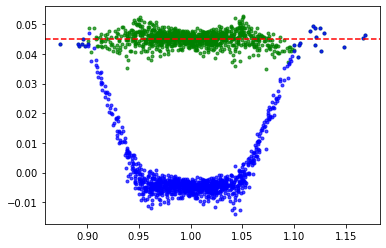

In [10]:
a = []
b = []

for i in range(M):
    cost = hedge = 0.
    for j in range(N):
        delta_1 = norm.cdf((np.log(S[i,j]/K_1)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_2 = norm.cdf((np.log(S[i,j]/K_2)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_3 = norm.cdf((np.log(S[i,j]/K_3)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_4 = norm.cdf((np.log(S[i,j]/K_4)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta = delta_1 - delta_2 - delta_3 + delta_4
        cost = cost + (delta - hedge) * S[i,j]
        hedge = delta
    cost = cost - hedge * S[i,N]
    a.append(cost)
    cost += (
        np.maximum(K_1-S[i,N], 0) - np.maximum(K_2-S[i,N], 0)
        - np.maximum(K_3-S[i,N], 0) + np.maximum(K_4-S[i,N], 0)
    )
    b.append(cost)

plt.plot(S[:,-1], b, marker=".", c="g", alpha=0.7, linestyle='none')
plt.plot(S[:,-1], a, marker=".", c="b", alpha=0.7, linestyle='none')
premium = (
    bsput(S0, K_1, T, r, sig) - bsput(S0, K_2, T, r, sig)
    - bsput(S0, K_3, T, r, sig) + bsput(S0, K_4, T, r, sig)
)
plt.axhline(y=premium, c='r', linestyle='--')
plt.show()



## Tensorflow Implementation

In [11]:
premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

inputs = [premium, hedge_cost, price]

for j in range(30):
    delta = delta_model(name='delta_model_%s' % j)(price)
    new_price = tf.keras.layers.Input(shape=(1,), name='S%s' % j)
    inputs.append(new_price)
    price_inc = tf.keras.layers.Subtract(name='price_inc_%s' % j)([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_%s" % j)([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_%s' % j)([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(
    lambda x : tf.math.maximum(K_1-x,0) - tf.math.maximum(K_2-x,0) - tf.math.maximum(K_3-x,0) + tf.math.maximum(K_4-x,0), 
    name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=inputs, outputs=cum_cost)
model.compile(loss='mse', optimizer='adam')
# model.summary()

In [12]:
premium = (
    bsput(S0,K_1,T,r,sig) * np.ones([M,1])
    - bsput(S0,K_2,T,r,sig) * np.ones([M,1])
    - bsput(S0,K_3,T,r,sig) * np.ones([M,1])
    + bsput(S0,K_4,T,r,sig) * np.ones([M,1])
)
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium] + [cost] + [SS]
y = np.zeros([M,1])

history = model.fit(x,y, batch_size=32, epochs=100,  verbose=True)

Epoch 1/100
32/32 [==============================] - 51s 92ms/step - loss: 3.8002e-04
Epoch 2/100
32/32 [==============================] - 3s 88ms/step - loss: 7.6906e-05
Epoch 3/100
32/32 [==============================] - 3s 95ms/step - loss: 3.5666e-05
Epoch 4/100
32/32 [==============================] - 3s 95ms/step - loss: 3.6167e-05
Epoch 5/100
32/32 [==============================] - 3s 94ms/step - loss: 3.0928e-05
Epoch 6/100
32/32 [==============================] - 3s 97ms/step - loss: 3.2339e-05
Epoch 7/100
32/32 [==============================] - 3s 89ms/step - loss: 3.0959e-05
Epoch 8/100
32/32 [==============================] - 3s 88ms/step - loss: 4.6124e-05
Epoch 9/100
32/32 [==============================] - 3s 96ms/step - loss: 4.2211e-05
Epoch 10/100
32/32 [==============================] - 3s 96ms/step - loss: 3.7043e-05
Epoch 11/100
32/32 [==============================] - 3s 95ms/step - loss: 3.4967e-05
Epoch 12/100
32/32 [==============================] - 3s 96ms/

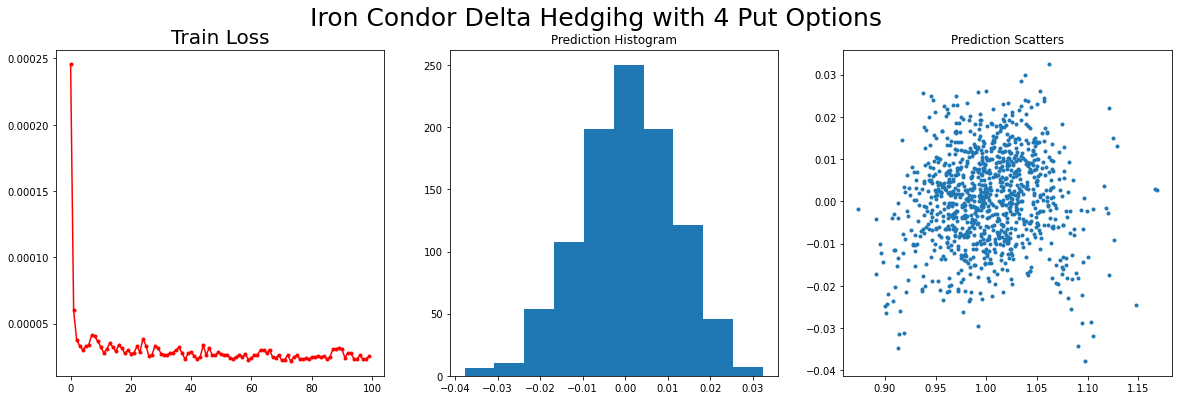

In [13]:
visualize(model, history, S, x, suptitle="Iron Condor Delta Hedgihg with 4 Put Options")

# Implementation with Call Options and Put Options

## Simulation

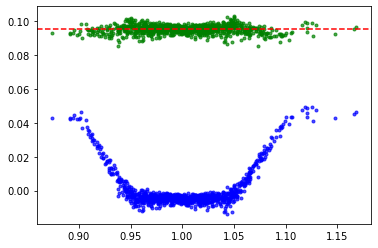

In [14]:
a = []
b = []

for i in range(M):
    cost = hedge = 0.
    for j in range(N):
        delta_1 = norm.cdf((np.log(S[i,j]/K_1)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_2 = norm.cdf((np.log(S[i,j]/K_2)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_3 = norm.cdf((np.log(S[i,j]/K_3)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta_4 = norm.cdf((np.log(S[i,j]/K_4)+(r-0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt)))
        delta = delta_1 - delta_2 - delta_3 + delta_4
        cost = cost + (delta - hedge) * S[i,j]
        hedge = delta
    cost = cost - hedge * S[i,N]
    a.append(cost)
    cost += (
        np.maximum(S[i,N]-K_1, 0) - np.maximum(S[i,N]-K_2, 0)
        - np.maximum(K_3-S[i,N], 0) + np.maximum(K_4-S[i,N], 0)
    )
    b.append(cost)

plt.plot(S[:,-1], b, marker=".", c="g", alpha=0.7, linestyle='none')
plt.plot(S[:,-1], a, marker=".", c="b", alpha=0.7, linestyle='none')
premium = (
    bscall(S0, K_1, T, r, sig) - bscall(S0, K_2, T, r, sig)
    - bsput(S0, K_3, T, r, sig) + bsput(S0, K_4, T, r, sig)
)
plt.axhline(y=premium, c='r', linestyle='--')
plt.show()


## Tensorflow Implementation

In [15]:
premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

inputs = [premium, hedge_cost, price]

for j in range(30):
    delta = delta_model(name='delta_model_%s' % j)(price)
    new_price = tf.keras.layers.Input(shape=(1,), name='S%s' % j)
    inputs.append(new_price)
    price_inc = tf.keras.layers.Subtract(name='price_inc_%s' % j)([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_%s" % j)([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_%s' % j)([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(
    lambda x : tf.math.maximum(x-K_1,0) - tf.math.maximum(x-K_2,0) - tf.math.maximum(K_3-x,0) + tf.math.maximum(K_4-x,0), 
    name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=inputs, outputs=cum_cost)
model.compile(loss='mse', optimizer='adam')
# model.summary()

In [16]:
premium = (
    bscall(S0,K_1,T,r,sig) * np.ones([M,1])
    - bscall(S0,K_2,T,r,sig) * np.ones([M,1])
    - bsput(S0,K_3,T,r,sig) * np.ones([M,1])
    + bsput(S0,K_4,T,r,sig) * np.ones([M,1])
)
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium] + [cost] + [SS]
y = np.zeros([M,1])

history = model.fit(x,y, batch_size=32, epochs=100,  verbose=True)

Epoch 1/100
32/32 [==============================] - 52s 95ms/step - loss: 2.9231e-04
Epoch 2/100
32/32 [==============================] - 3s 87ms/step - loss: 5.5254e-05
Epoch 3/100
32/32 [==============================] - 3s 82ms/step - loss: 3.3729e-05
Epoch 4/100
32/32 [==============================] - 3s 88ms/step - loss: 3.4131e-05
Epoch 5/100
32/32 [==============================] - 3s 90ms/step - loss: 3.9548e-05
Epoch 6/100
32/32 [==============================] - 3s 92ms/step - loss: 3.1779e-05
Epoch 7/100
32/32 [==============================] - 3s 90ms/step - loss: 3.5034e-05
Epoch 8/100
32/32 [==============================] - 3s 93ms/step - loss: 2.8512e-05
Epoch 9/100
32/32 [==============================] - 3s 89ms/step - loss: 3.4913e-05
Epoch 10/100
32/32 [==============================] - 3s 90ms/step - loss: 3.3324e-05
Epoch 11/100
32/32 [==============================] - 3s 98ms/step - loss: 2.9988e-05
Epoch 12/100
32/32 [==============================] - 3s 97ms/

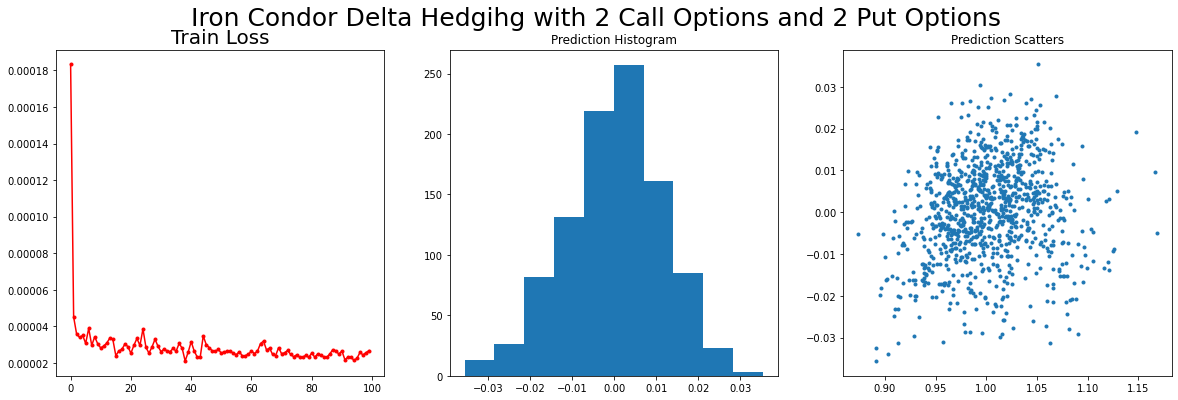

In [17]:
visualize(model, history, S, x, suptitle="Iron Condor Delta Hedgihg with 2 Call Options and 2 Put Options")

* Call Option + Put Option was hardest to train, I think.

# Pytorch Implementations

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1234)
np.random.seed(1234)


class MyModel(nn.Module): ...
    